In [3]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# import pandas as pd

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [4]:
def output_image(file_name, mask_name):
    # Loading in Image

    img_nifti = nib.load(file_name)

    img =img_nifti.dataobj[:,:,:,:]

    # Loading in Mask 

    mask_nifti = nib.load(mask_name)

    mask = mask_nifti.dataobj[:,:,:]

    # Final Image 

    arr = img.copy()
    for i in range (0,1344):
        arr[:,:,:,i] = mask*img[:,:,:,i]; 
        
    return arr, mask

In [5]:
# Training Images
arr1, mask1 = output_image("cdmri11_r.nii", "cdmri11_mask.nii")
# arr2, mask2 = output_image("cdmri12_r.nii", "cdmri12_mask.nii")

# Validation Image
# arr3, mask3 = output_image("cdmri13_r.nii", "cdmri13_mask.nii")

# Test Images
# arr4, mask4 = output_image("cdmri14_r.nii", "cdmri14_mask.nii")
# arr5, mask5 = output_image("cdmri15_r.nii", "cdmri15_mask.nii")

In [6]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]

In [7]:
def selecting_right_params(im_arr, indices): 

    res_selected = im_arr[:,:,:,indices]
    
    return res_selected

In [8]:
res_sel_1 = selecting_right_params(arr1, indices)
# res_sel_2 = selecting_right_params(arr2, indices)
# res_sel_3 = selecting_right_params(arr3, indices)
# res_sel_4 = selecting_right_params(arr4, indices)
# res_sel_5 = selecting_right_params(arr5, indices)

In [9]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

# s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]

<h2> Selecting for Separate Effects </h2> 

In [10]:
# Extract indices

# Diffusion
low_TE_ind = np.where(TE<100)
high_TI_ind = np.where(TI>4600) # First trial was 1500
diff_ind_1 = np.intersect1d(high_TI_ind, low_TE_ind, assume_unique=True)

# T1
low_TE_ind = np.where(TE<100)
b_ind = np.where(b==0)
diff_ind_2 = np.intersect1d(b_ind, low_TE_ind, assume_unique=True)

# T2
high_TI_ind = np.where(TI>3200)
b_ind = np.where(b==0)
diff_ind_3 = np.intersect1d(b_ind, high_TI_ind, assume_unique=True)

In [11]:
# Combining
diff_ind = np.concatenate((diff_ind_1, diff_ind_2, diff_ind_3))

In [12]:
# Select Relevant Data
b = b[diff_ind]
TI = TI[diff_ind]
TE = TE[diff_ind]
param = param[diff_ind,:]

In [13]:
res_sel_1 = res_sel_1[:,:,:,:,diff_ind]
# res_sel_2 = res_sel_2[:,:,:,:,diff_ind]
# res_sel_3 = res_sel_3[:,:,:,:,diff_ind]
# res_sel_4 = res_sel_4[:,:,:,:,diff_ind]
# res_sel_5 = res_sel_5[:,:,:,:,diff_ind]

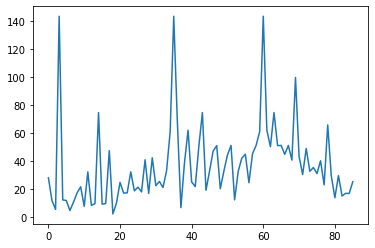

In [14]:
plt.plot(res_sel_1[40,40,33,0,:])

In [15]:
diff_ind

array([  22,   26,   49,   53,   76,   80,  103,  107,  130,  134,  157,
        161,  184,  188,  211,  215,  238,  242,  265,  269,  292,  296,
        319,  323,  346,  350,  373,  377,  400,  404,  427,  431,   50,
         51,   52,   53,  111,  112,  113,  114,  208,  209,  210,  211,
        258,  259,  260,  261,  277,  278,  279,  280,  362,  363,  364,
        365,  378,  379,  380,   52,   53,  114,  210,  211,  261,  280,
        365,  380,  484,  485,  546,  642,  643,  693,  712,  797,  812,
        916,  917,  978, 1074, 1075, 1125, 1144, 1229, 1244], dtype=int64)

In [16]:
np.savetxt('combined_diff_ind.txt', diff_ind)

<h2> Creating Training and Test Sets </h2> 

In [ ]:
# Importing Features

CSF_S11 = nib.load(datafolder+"CSF_S11.nii")
WM_S11 = nib.load(datafolder+"WM_S11.nii")
GM_S11 = nib.load(datafolder+"GM_S11.nii")

CSF_S12 = nib.load(datafolder+"CSF_S12.nii")
WM_S12 = nib.load(datafolder+"WM_S12.nii")
GM_S12 = nib.load(datafolder+"GM_S12.nii")

CSF_S13 = nib.load(datafolder+"CSF_S13.nii")
WM_S13 = nib.load(datafolder+"WM_S13.nii")
GM_S13 = nib.load(datafolder+"GM_S13.nii")


In [ ]:
Label_CSF = [ CSF_S11.dataobj[:,:,:], CSF_S12.dataobj[:,:,:], CSF_S13.dataobj[:,:,:]]
Label_WM = [ WM_S11.dataobj[:,:,:], WM_S12.dataobj[:,:,:], WM_S13.dataobj[:,:,:]]
Label_GM = [ GM_S11.dataobj[:,:,:], GM_S12.dataobj[:,:,:], GM_S13.dataobj[:,:,:]]

In [ ]:
# Definitions before Looping
conf_mat_collection = np.zeros((3,3,5))
conf_mat_collection_rfe = np.zeros((3,3,5))

In [ ]:
# Initialising all definitions
def create_labelled_data(Label_CSF, Label_WM, Label_GM, param, res_selected):
    
    # Data Size
    CSF_num = np.asarray(np.nonzero(Label_CSF)).shape[1]
    WM_num = np.asarray(np.nonzero(Label_WM)).shape[1]
    GM_num = np.asarray(np.nonzero(Label_GM)).shape[1]
    rows = CSF_num + WM_num + GM_num
    
    # Setting Key and Creating Labelled Data

    ## Key ---------------------------------------
    # 1 - WM                                     \
    # 2 - GM                                     \
    # 3 - CSF                                    \
    # --------------------------------------------

    # Creating Labelled Data
    labelled_data_org_pos = np.zeros([rows,4])

     # WM values
    coords_WM = np.transpose(np.asarray((np.nonzero(Label_WM))))
    label_WM = np.c_[coords_WM, np.transpose(np.ones([1,WM_num]))]
    labelled_data_org_pos[0:WM_num,:] = label_WM

    # GM values
    coords_GM = np.transpose(np.asarray((np.nonzero(Label_GM))))
    label_GM = np.c_[coords_GM, np.transpose(2*np.ones([1,GM_num]))]
    labelled_data_org_pos[WM_num:(WM_num+GM_num),:] = label_GM

    # CSF values
    coords_CSF = np.transpose(np.asarray((np.nonzero(Label_CSF))))
    label_CSF = np.concatenate((coords_CSF, np.transpose(3*np.ones([1,CSF_num]))),axis = 1 )
    labelled_data_org_pos[(WM_num+GM_num):(GM_num+CSF_num+WM_num),:] = label_CSF
    
    labelled_data_org_pos = labelled_data_org_pos.astype(int)

    total_num_labels = labelled_data_org_pos.shape[0]

    # Full Labelled Data
    col = param.shape[0]+1 # 1296 for different parameter values, 1 for labels
    param_num = param.shape[0]
    full_label_data = np.zeros([total_num_labels,col]) # 1296 for different parameter values, 1 for labels
    full_label_data[:,-1] = labelled_data_org_pos[:,-1]
    unlabelled_data = res_selected.copy()
    for i in range (0,total_num_labels):
        full_label_data[i,:-1] = res_selected[labelled_data_org_pos[i,0], labelled_data_org_pos[i,1], labelled_data_org_pos[i,2],:]

    return full_label_data, unlabelled_data


In [ ]:
def pred_results_train(clf, X_test, full_label_data, res_sel, mask, scan_num): 
    
    # Predict Labels
    y_predicted = clf.predict(X_test)
    y_predicted = np.reshape(y_predicted, (res_sel.shape[:-1]))    
    result = y_predicted * mask
    
    # Confusion Matrix
    y_predicted_train = clf.predict(full_label_data[:,:-1])
    conf_mat = confusion_matrix(full_label_data[:,-1], y_predicted_train)
    
    # Getting accuracy
    labels_predicted = clf.predict(full_label_data)
    acc = clf.score(full_label_data[:,:-1],full_label_data[:,-1]) 
    print('Model Accuracy Score Scan' ,scan_num , ' : ', acc )
    
    # Probabilistic Results
    predicted_probs = clf.predict_proba(X_test)
    predicted_probs = np.reshape(predicted_probs, np.append(res_sel.shape[:-1], 3))

    # Creating pixel values as a weighted sum of colors
    predicted_probs_color = predicted_probs * 255 
    
    # Displaying Result

    # 1 WM Red
    # 2 GM Green
    # 3 CSF Blue

    prob_result = predicted_probs_color;
    prob_result[:,:,:,0] = prob_result[:,:,:,0]*mask
    prob_result[:,:,:,1] = prob_result[:,:,:,1]*mask
    prob_result[:,:,:,2] = prob_result[:,:,:,2]*mask

    return result, prob_result, conf_mat
    

In [ ]:
def pred_results(clf, X_test, y_test, X_test_im, res_sel, mask, scan_num): 
    # Predict Labels
    y_predicted = clf.predict(X_test)
    acc = clf.score(X_test, y_test) 
    print('Model Accuracy Score Scan' ,scan_num , ' : ', acc )
    
    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_predicted)
    
    # Predicting Image
    y_predicted_im = clf.predict(X_test_im)    
    y_predicted_im = np.reshape(y_predicted_im, (res_sel.shape[:-1]))    
    result = y_predicted_im * mask
          
    # Probabilistic Results
    predicted_probs = clf.predict_proba(X_test_im)
    predicted_probs = np.reshape(predicted_probs, np.append(res_sel.shape[:-1], 3))

    # Creating pixel values as a weighted sum of colors
    predicted_probs_color = predicted_probs * 255 
    
    # Displaying Result

    # 1 WM Red
    # 2 GM Green
    # 3 CSF Blue

    prob_result = predicted_probs_color;
    prob_result[:,:,:,0] = prob_result[:,:,:,0]*mask
    prob_result[:,:,:,1] = prob_result[:,:,:,1]*mask
    prob_result[:,:,:,2] = prob_result[:,:,:,2]*mask
    
    return result, prob_result, conf_mat

In [ ]:
res_sel_1= np.squeeze(res_sel_1)
res_sel_2= np.squeeze(res_sel_2)
res_sel_3= np.squeeze(res_sel_3)
res_sel_4= np.squeeze(res_sel_4)
res_sel_5= np.squeeze(res_sel_5)

In [ ]:
full_label_data_S11, unlabelled_data_S11 = create_labelled_data(Label_CSF[0], Label_WM[0], Label_GM[0], param, res_sel_1)
full_label_data_S12, unlabelled_data_S12 = create_labelled_data(Label_CSF[1], Label_WM[1], Label_GM[1], param, res_sel_2)
full_label_data_S13, unlabelled_data_S13 = create_labelled_data(Label_CSF[2], Label_WM[2], Label_GM[2], param, res_sel_3)
full_label_data = np.concatenate((full_label_data_S11, full_label_data_S12, full_label_data_S13), 0)

In [ ]:
# Creating Train and 'Test' Sets

X_train = full_label_data[:,:-1]
y_train = full_label_data[:,-1]

param_num = param.shape[0]
res_sel_1_reshape_dim = res_sel_1.shape[0]*res_sel_1.shape[1]*res_sel_1.shape[2]
res_sel_2_reshape_dim = res_sel_2.shape[0]*res_sel_2.shape[1]*res_sel_2.shape[2]
res_sel_3_reshape_dim = res_sel_3.shape[0]*res_sel_3.shape[1]*res_sel_3.shape[2]

X_test_S11 = np.reshape(unlabelled_data_S11, (res_sel_1_reshape_dim ,param_num)) 
X_test_S12 = np.reshape(unlabelled_data_S12, (res_sel_2_reshape_dim ,param_num)) 
X_test_S13 = np.reshape(unlabelled_data_S13, (res_sel_3_reshape_dim ,param_num))

<h2> Training Model </h2>  

In [ ]:
# Performing Random Forest Classification

clf=RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0, max_features=None,  n_jobs= -1)
clf.fit(X_train,y_train)

# Grid Search
# Specify parameters and parameter distributions

param_dist = {"max_depth": [3, 5, 10, 20, 50],
              "max_features" : [None],
              "n_estimators": [10,20,50,100]
              }

# GridSearchCV Instance
grid = GridSearchCV(estimator=clf, param_grid=param_dist,cv=10,iid=False, n_jobs= -1)
# Perform Grid Search  
grid.fit(X_train, y_train)

# summarize the results of the grid search
print('Best classification score achieved using grid search:', grid.best_score_)
print('The parameters resulting in the best score are: depth {},max_f {} and n_estimators {} '\
      .format(grid.best_estimator_.max_depth,grid.best_estimator_.max_features,\
              grid.best_estimator_.n_estimators))

# Create RF model using optimised parameters
clf=RandomForestClassifier(max_depth=grid.best_estimator_.max_depth,max_features=\
                            grid.best_estimator_.max_features,\
                            n_estimators=grid.best_estimator_.n_estimators,
                            random_state=42)
clf.fit(X_train,y_train)


In [ ]:
# Feature Importances
plt.figure(figsize = [16,4])
n_features = X_train.shape[1]
plt.bar(np.arange(n_features),clf.feature_importances_)
plt.title('Feature importances', fontsize = 18)
plt.xlabel('Features', fontsize = 16)
plt.ylabel('importances', fontsize = 16)

feature_imp = np.zeros((2, param.shape[0]))
feature_imp[0,:] = np.arange(param.shape[0])
feature_imp[1,:] = cl.feature_importances_

<h2> Displaying and Predicting Results </h2>

In [ ]:
# Initialising matrices to store results

ims1 = np.zeros((res_sel_1.shape[0],res_sel_1.shape[1], res_sel_1.shape[2], 4))
ims2 = np.zeros((res_sel_2.shape[0],res_sel_2.shape[1], res_sel_2.shape[2], 4))
ims3 = np.zeros((res_sel_3.shape[0],res_sel_3.shape[1], res_sel_3.shape[2], 4))
ims4 = np.zeros((res_sel_4.shape[0],res_sel_4.shape[1], res_sel_4.shape[2], 4))
ims5 = np.zeros((res_sel_5.shape[0],res_sel_5.shape[1], res_sel_5.shape[2], 4))

In [ ]:
ims1[:,:,:,0] , ims1[:,:,:,1:4], conf_mat_1 = pred_results_train(clf, X_test_S11, full_label_data_S11, res_sel_1, mask1 , 11)

In [ ]:
ims2[:,:,:,0] , ims2[:,:,:,1:4], conf_mat_2 = pred_results_train(clf, X_test_S12, full_label_data_S12, res_sel_2, mask2 , 12)

In [ ]:
ims3[:,:,:,0] , ims3[:,:,:,1:4], conf_mat_3 = pred_results_train(clf, X_test_S13, full_label_data_S13, res_sel_3, mask3 , 13)

<h2> Test Sets </h2>

In [ ]:
# Creating Test Sets

# Scan 14
# Importing Features
CSF_S14 = nib.load(datafolder+"CSF_S14.nii")
WM_S14 = nib.load(datafolder+"WM_S14.nii")
GM_S14 = nib.load(datafolder+"GM_S14.nii")

Label_CSF_S14 = CSF_S14.dataobj[:,:,:]
Label_WM_S14 = WM_S14.dataobj[:,:,:]
Label_GM_S14 = GM_S14.dataobj[:,:,:]

full_label_data_S14, unlabelled_data_S14 = create_labelled_data(Label_CSF_S14, Label_WM_S14, Label_GM_S14, param, res_sel_4)

X_test_S14 = full_label_data_S14[:,:-1]
y_test_S14 = full_label_data_S14[:,-1]

res_sel_4_reshape_dim = res_sel_4.shape[0]*res_sel_4.shape[1]*res_sel_4.shape[2]

X_test_S14_im = np.reshape(unlabelled_data_S14, (res_sel_4_reshape_dim ,param_num)) 

In [ ]:
# Scan 15
# Importing Features
CSF_S15 = nib.load(datafolder+"CSF_S15.nii")
WM_S15 = nib.load(datafolder+"WM_S15.nii")
GM_S15 = nib.load(datafolder+"GM_S15.nii")

Label_CSF_S15 = CSF_S15.dataobj[:,:,:]
Label_WM_S15 = WM_S15.dataobj[:,:,:]
Label_GM_S15 = GM_S15.dataobj[:,:,:]

full_label_data_S15, unlabelled_data_S15 = create_labelled_data(Label_CSF_S15, Label_WM_S15, Label_GM_S15, param, res_sel_5)

X_test_S15 = full_label_data_S15[:,:-1]
y_test_S15 = full_label_data_S15[:,-1]

res_sel_5_reshape_dim = res_sel_5.shape[0]*res_sel_5.shape[1]*res_sel_5.shape[2]

X_test_S15_im = np.reshape(unlabelled_data_S15, (res_sel_5_reshape_dim ,param_num)) 

In [ ]:
ims4[:,:,:,0] , ims4[:,:,:,1:4], conf_mat_4 =  pred_results(clf, X_test_S14, y_test_S14, X_test_S14_im, res_sel_4, mask4, 14)

In [ ]:
ims4[:,:,:,0] , ims4[:,:,:,1:4], conf_mat_5 = pred_results(clf, X_test_S15, y_test_S15, X_test_S15_im, res_sel_5, mask5, 15)

In [ ]:
# Saving conf_mat into whole array
conf_mat_collection[:,:,0] = conf_mat_1
conf_mat_collection[:,:,1] = conf_mat_2
conf_mat_collection[:,:,2] = conf_mat_3
conf_mat_collection[:,:,3] = conf_mat_4
conf_mat_collection[:,:,4] = conf_mat_5

In [ ]:
# Saving files
np.save('conf_mat_combined.npy', conf_mat_collection)
np.savetxt('combined_feature_imp.txt', feature_imp)

nifti1 = nib.Nifti1Image(ims1, affine = None)
nib.save(nifti1, 'combined_rf_S1.nii')
nifti2 = nib.Nifti1Image(ims2, affine = None)
nib.save(nifti2, 'combined_rf_S2.nii')
nifti3 = nib.Nifti1Image(ims3, affine = None)
nib.save(nifti3, 'combined_rf_S3.nii')
nifti4 = nib.Nifti1Image(ims4, affine = None)
nib.save(nifti4, 'combined_rf_S4.nii')
nifti5 = nib.Nifti1Image(ims5, affine = None)
nib.save(nifti5, 'combined_rf_S5.nii')